### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]17:13:47 Initiating the NLP Engine
[INFO]17:13:47 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL.txt is being ported to dataframe
[INFO]17:13:47 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL.txt has been ported to dataframe
[INFO]17:13:47 Trimming data and preparing list of words
[['Title,Authors,Journal and Dates,Abstract'], ['Interacting effects of land use and climate on rodent-borne pathogens in central Kenya,"By: Young, Hillary S.; McCauley, Douglas J.; Dirzo, Rodolfo; et al.",PHILOSOPHICAL TRANSACTIONS OF THE ROYAL SOCIETY B-BIOLOGICAL SCIENCES  Volume: 372   Issue: 1722     Article Number: 20160116   Published: JUN 5 2017,"Understanding the effects of anthropogenic disturbance on zoonotic disease risk is both a critical conservation objective and a public health priority. Here, we evaluate the effects of multiple forms of anthropogenic disturbance across a precipitation gradient on the abundance of pathogen-infected small ma

[INFO]17:13:47 Generating bigrams
[INFO]17:13:47 Generating word bigrams
[INFO]17:13:49 Generated word bigrams
[INFO]17:13:49 Beginning lemmatization
[INFO]17:13:53 Ending lemmatization
[INFO]17:13:57 Issued perplexity: -9.323515524896138
[INFO]17:13:57 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.034*"mammal" + 0.023*"tbe" + 0.023*"tick" + 0.017*"infection" + 0.015*"show" + 0.013*"antibody" + 0.012*"host" + 0.012*"germany" + 0.010*"site" + 0.010*"foci"'),
 (1,
  '0.011*"article" + 0.010*"haemosporidian" + 0.009*"systematic" + 0.007*"avian" + 0.005*"virulent" + 0.005*"strength" + 0.004*"exo_erythrocytic" + 0.004*"plasmodium" + 0.003*"legged" + 0.003*"haemosporida"'),
 (2,
  '0.061*"structure" + 0.054*"scale" + 0.048*"body_mass" + 0.045*"process" + 0.035*"ecosystem" + 0.033*"animal" + 0.022*"size" + 0.022*"discontinuous" + 0.018*"texture" + 0.017*"time"'),
 (3,
  '0.046*"plague" + 0.037*"deer" + 0.028*"flea" + 0.015*"prairie_dogs" + 0.015*"colony" + 0.009*"coyote" + 0.008*"black_taile" + 0.008*"prairie_dog" + 0.008*"bacterium" + 0.007*"peromyscus"'),
 (4,
  '0.025*"bird" + 0.021*"landscape" + 0.020*"clump" + 0.014*"mammal" + 0.013*"host" + 0.012*"range" + 0.012*"distribution" + 0.010*"spatial" + 0.010*"frequency" + 0.010*"show"'),
 (5,
  '0.014*"freshwater" + 0.012*"cra

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(3,
  [('disease', 0.13720316622691292),
   ('human', 0.048812664907651716),
   ('risk', 0.03715919085312225),
   ('wildlife', 0.02660510114335972),
   ('transmission', 0.026385224274406333),
   ('increase', 0.026165347405452948),
   ('potential', 0.021767810026385226),
   ('mammal', 0.015391380826737027),
   ('dog', 0.013852242744063324),
   ('factor', 0.013852242744063324)]),
 (8,
  [('mammal', 0.018361581920903956),
   ('gene', 0.016713747645951037),
   ('sequence', 0.012476459510357816),
   ('strain', 0.011534839924670434),
   ('dna', 0.011299435028248588),
   ('diet', 0.01059322033898305),
   ('captive', 0.010357815442561206),
   ('genetic', 0.009887005649717515),
   ('identify', 0.009887005649717515),
   ('present', 0.009416195856873822)]),
 (1,
  [('infection', 0.05384079832907867),
   ('reservoir', 0.03365049895567417),
   ('rodent', 0.0329542817359016),
   ('ecology', 0.030865630076583894),
   ('animal', 0.023439313065676492),
   ('disease', 0.021350661406358783),
   ('popula

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3980933978092885


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

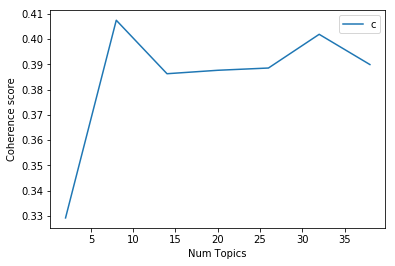

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.064*"tick" + 0.030*"host" + 0.021*"mammal" + 0.016*"mouse" + 0.015*"lyme" '
  '+ 0.015*"deer" + 0.015*"site" + 0.014*"vector" + 0.013*"infection" + '
  '0.013*"feed" + 0.013*"tick_borne" + 0.012*"number" + 0.011*"rodent" + '
  '0.011*"increase" + 0.011*"eastern" + 0.011*"nymph" + 0.010*"infect" + '
  '0.010*"density" + 0.010*"year" + 0.009*"larvae" + 0.008*"journal" + '
  '0.008*"suggest" + 0.007*"rate" + 0.007*"borrelia_burgdorferi" + '
  '0.007*"larval" + 0.007*"burgdorferi" + 0.007*"adult" + 0.007*"volume_issue" '
  '+ 0.006*"vole" + 0.006*"abundance" + 0.005*"ixode" + 0.005*"collect" + '
  '0.005*"infestation" + 0.005*"tbe" + 0.005*"immature" + 0.005*"prevalence" + '
  '0.005*"northern" + 0.005*"role" + 0.005*"coyote" + 0.005*"high"'),
 (1,
  '0.054*"infection" + 0.034*"reservoir" + 0.033*"rodent" + 0.031*"ecology" + '
  '0.023*"animal" + 0.021*"disease" + 0.020*"population" + '
  '0.019*"volume_issue" + 0.018*"associate" + 0.016*"rat" + 0.016*"zoonotic" + '
  '0.014*"tes

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.0975,"animal, research, ecology, datum, wild, pages_...","[Title,Authors,Journal and Dates,Abstract]"
1,1,5.0,0.2725,"abundance, effect, forest, change, mammal, hab...",[Interacting effects of land use and climate o...
2,2,11.0,0.2814,"host, pathogen, community, diversity, transmis...",[Detecting signals of chronic shedding to expl...
3,3,1.0,0.2859,"infection, reservoir, rodent, ecology, animal,...",[Broad and flexible stable isotope niches in i...
4,4,9.0,0.2915,"parasite, vector, host, result, mosquito, tran...",[Picky eaters are rare: DNA-based blood meal a...
5,5,4.0,0.3197,"population, bat, individual, model, rate, move...",[Hung out to dry? Intraspecific variation in w...
6,6,9.0,0.4315,"parasite, vector, host, result, mosquito, tran...",[Exo-erythrocytic development of avian malaria...
7,7,4.0,0.3019,"population, bat, individual, model, rate, move...","[Demographic, ecological, and physiological re..."
8,8,4.0,0.2259,"population, bat, individual, model, rate, move...",[Joint associations of blood plasma proteins w...
9,9,0.0,0.3040,"tick, host, mammal, mouse, lyme, deer, site, v...",[Synanthropic Mammals as Potential Hosts of Ti...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"animal, research, ecology, datum, wild, pages_...",48.0,0.1188
1,5.0,"abundance, effect, forest, change, mammal, hab...",24.0,0.0594
2,11.0,"host, pathogen, community, diversity, transmis...",31.0,0.0767
3,1.0,"infection, reservoir, rodent, ecology, animal,...",25.0,0.0619
4,9.0,"parasite, vector, host, result, mosquito, tran...",37.0,0.0916
5,4.0,"population, bat, individual, model, rate, move...",40.0,0.0990
6,9.0,"parasite, vector, host, result, mosquito, tran...",35.0,0.0866
7,4.0,"population, bat, individual, model, rate, move...",30.0,0.0743
8,4.0,"population, bat, individual, model, rate, move...",31.0,0.0767
9,0.0,"tick, host, mammal, mouse, lyme, deer, site, v...",31.0,0.0767


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     50.539566        1       1  0.204483  0.154899
4      18.423534        1       2  0.267823 -0.031346
0      13.556931        1       3  0.260130  0.197792
9       8.366940        1       4  0.063046  0.047115
2       1.992678        1       5  0.212560 -0.367207
8       1.927432        1       6 -0.147515  0.002479
3       1.689457        1       7 -0.151647 -0.003285
7       1.548242        1       8 -0.150487 -0.006701
11      1.097067        1       9 -0.148720 -0.005369
1       0.347862        1      10 -0.136945  0.003415
5       0.268871        1      11 -0.136984  0.003876
6       0.241419        1      12 -0.135745  0.004331, topic_info=     Category        Freq           Term       Total  loglift  logprob
4217  Default  300.000000         animal  300.000000  30.0000  30.0000
36    Default  523.000000     population  523.000000  29.0000  29.0000
7780  Default  130.000000      structure  130.000000  28.0000  28.0000
7676  Default  855.000000         mammal  855.000000  27.0000  27.0000
2172  Default  114.000000          scale  114.000000  26.0000  26.0000
3002  Default  345.000000           bird  345.000000  25.0000  25.0000
1671  Default  186.000000            tbe  186.000000  24.0000  24.0000
7162  Default  181.000000           tick  181.000000  23.0000  23.0000
553   Default  313.000000      infection  313.000000  22.0000  22.0000
5101  Default  270.000000      landscape  270.000000  21.0000  21.0000
5085  Default   89.000000        process   89.000000  20.0000  20.0000
4821  Default  243.000000          clump  243.000000  19.0000  19.0000
7782  Default   77.000000      ecosystem   77.000000  18.0000  18.0000
965   Default  646.000000          virus  646.000000  17.0000  17.0000
5322  Default  179.000000       parasite  179.000000  16.0000  16.0000
5520  Default  246.000000           show  246.000000  15.0000  15.0000
7253  Default  103.000000      community  103.000000  14.0000  14.0000
4215  Default   96.000000           time   96.000000  13.0000  13.0000
198   Default  143.000000          large  143.000000  12.0000  12.0000
6610  Default  133.000000        habitat  133.000000  11.0000  11.0000
8327  Default   56.000000      body_mass   56.000000  10.0000  10.0000
4913  Default  149.000000           rate  149.000000   9.0000   9.0000
2201  Default  384.000000           host  384.000000   8.0000   8.0000
5870  Default   88.000000           fall   88.000000   7.0000   7.0000
3511  Default   87.000000         length   87.000000   6.0000   6.0000
7680  Default  117.000000       antibody  117.000000   5.0000   5.0000
1410  Default  178.000000          range  178.000000   4.0000   4.0000
2674  Default  190.000000        isolate  190.000000   3.0000   3.0000
5750  Default   81.000000           mass   81.000000   2.0000   2.0000
222   Default   79.000000         remote   79.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
235   Topic12    0.193273          guild    0.821552   4.5793  -6.5944
6466  Topic12    0.191442         julian    0.819749   4.5720  -6.6039
4349  Topic12    0.165643      meanwhile    0.793922   4.4592  -6.7487
4881  Topic12    0.161701       contract    0.790023   4.4401  -6.7728
6690  Topic12    0.159345       instance    0.890427   4.3058  -6.7874
4086  Topic12    0.090603           neck    0.718883   3.9552  -7.3520
2034  Topic12    0.090603         muneza    0.718883   3.9552  -7.3520
1333  Topic12    0.090603     respondent    0.718883   3.9552  -7.3520
861   Topic12    0.090603        wrinkle    0.718883   3.9552  -7.3520
7513  Topic12    0.090603           drop    0.718883   3.9552  -7.3520
296   Topic12    0.090603     montgomery    0.718883   3.9552  -7.3520
2592  Topic12    0.090603       shoulder    0.718883   3.9552  -7.3520
6955  Topic12    0.090603         arthur    0.718883   3.9552  -7.3520
2204  

In [1]:
import dill

In [3]:
dill.dump_session('databases/BarbaraData.db')

In [2]:
dill.load_session('databases/BarbaraData.db')